# TASK 3.1
Development of a classification model for discriminating between 2 classes: masses and calcification. Training of popular CNN architecture.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%tensorflow_version 2.x
import os
import itertools
import numpy as np
import tensorflow as tf
import random as rn
import matplotlib.pyplot as plt
from skimage import exposure
from tensorflow.compat.v1.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from keras.applications import VGG16, InceptionV3, ResNet50
from keras.applications.vgg16 import preprocess_input as vgg_process_input
from keras.applications.resnet50 import preprocess_input as resnet_process_input
from keras.applications.inception_v3 import preprocess_input as inception_process_input


# Parameters
DIR_PATH = '/content/drive/Shareddrives/Verna_Minutella_Veltroni'
MODEL_PATH = os.path.join(DIR_PATH, 'models/models_task3_1') 
NUMPY_PATH = os.path.join(DIR_PATH, 'numpy_data')

BATCH_SIZE = 128

# Set seed for reproducibility
tf.keras.backend.clear_session()

seed_num = 1
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(seed_num)
rn.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

### Utility function definition

#### Loading training and test sets

In [ ]:
# Loading training set and test set
def load_training():
  images = np.load(os.path.join(NUMPY_PATH,'train_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'train_labels.npy'))
  return images, labels

def load_test():
  images = np.load(os.path.join(NUMPY_PATH,'public_test_tensor.npy'))
  labels = np.load(os.path.join(NUMPY_PATH,'public_test_labels.npy'))
  return images, labels


#### Setting the seed


In [ ]:
# function to set the seed before each execution of the model
def set_seed():
    tf.keras.backend.clear_session()

    seed_num = 1
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_num)
    rn.seed(seed_num)
    tf.random.set_seed(seed_num)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

#### Plotting the confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Specificity : ', specificity )

    sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    print('Sensitivity : ', sensitivity)
    plt.show()

#### Plotting the ROC curve

In [ ]:
def plot_roc_curve(model, test_im, test_labels):
    probs = model.predict(test_im)
    fpr, tpr, threshold = roc_curve(test_labels, probs)
    roc_auc = auc(fpr, tpr) 
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Plotting the accuracy and loss trends


In [ ]:
# Utility function for plotting accuracy and loss function

def performance_plot(history, model, test_generator):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  fig1 = plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  t_images = test_generator[0][0]
  t_labels = test_generator[0][1]
  pred_labels = model.predict(t_images)
  pred_labels = np.rint(pred_labels)
  cm = confusion_matrix(t_labels, pred_labels)
  plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion matrix')
  #print(confusion_matrix(test_labels, pred_labels))

  print(classification_report(t_labels, pred_labels, digits=4))

  plot_roc_curve(model, t_images, t_labels)

### Dataset creation
We take the original dataset with five labels: we discard the label '0', which correspond to baseline patch, because we are considering only the abnormalities, and we aggregate label '1' and '2', which both correspond to masses, and label '3' and '4', which are both calcifications.


In [ ]:
train_img, train_lab = load_training()
test_img, test_lab = load_test()


In [ ]:
# TRAINING SET
abnormality_images = train_img[1::2] 
abnormality_labels = train_lab[1::2]

abnormality_images = abnormality_images.reshape((2676, 150, 150, 1)) 
abnormality_images = abnormality_images.astype('float32') * 0.003891051

# mass
abnormality_labels[abnormality_labels == 1] = 0
abnormality_labels[abnormality_labels == 2] = 0
# calcification
abnormality_labels[abnormality_labels == 3] = 1
abnormality_labels[abnormality_labels == 4] = 1


# VALIDATION SET
train_images, valid_images, train_labels, valid_labels = train_test_split(abnormality_images, abnormality_labels, test_size=0.20, shuffle=True, random_state=42, stratify=abnormality_labels)

# bisogna ripetere i layer, le reti note sono trainate su imagenet (immagini a colori)
train_images = np.repeat(train_images, 3, axis=3)
valid_images = np.repeat(valid_images, 3, axis=3)


# TEST SET
test_images = test_img[1::2]
test_labels = test_lab[1::2]

test_images = test_images.reshape((336, 150, 150, 1))
test_images = test_images.astype('float32') * 0.003891051

# mass
test_labels[test_labels == 1] = 0
test_labels[test_labels == 2] = 0
# calcification
test_labels[test_labels == 3] = 1
test_labels[test_labels == 4] = 1

test_images = np.repeat(test_images, 3, axis=3)


print("Original training set")
print(abnormality_labels.shape)
print(abnormality_images.shape)
print("Training set")
print(train_labels.shape)
print(train_images.shape)
print("Validation set")
print(valid_labels.shape)
print(valid_images.shape)
print("Test set")
print(test_labels.shape)
print(test_images.shape)
print(train_images.max())

Original training set
(2676,)
(2676, 150, 150, 1)
Training set
(2140,)
(2140, 150, 150, 3)
Validation set
(536,)
(536, 150, 150, 3)
Test set
(336,)
(336, 150, 150, 3)
255.00003


## VGG Net 16

### Preprocessing

In [ ]:
vgg_train_datagen = ImageDataGenerator(
    preprocessing_function=vgg_process_input,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

vgg_datagen = ImageDataGenerator(
     preprocessing_function=vgg_process_input
)

In [ ]:
vgg_train_datagen.fit(train_images)
vgg_train_generator = vgg_train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

vgg_validation_generator = vgg_datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)

vgg_test_generator = vgg_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0], shuffle=False)

### Model definition

In [ ]:
def vgg_creation(fc_dense = [512], summary = True):
    input_shape = (150, 150, 3)
    vgg_base = VGG16(weights='imagenet',
                    include_top = False,
                    input_shape=input_shape)

    vgg_base.trainable = False

    vgg = models.Sequential()
    vgg.add(vgg_base)
    vgg.add(layers.Flatten())
   
    for d in fc_dense:
      if d < 1:
        vgg.add(layers.Dropout(d))
      else:
        vgg.add(layers.Dense(d, activation='relu'))
    vgg.add(layers.Dense(1, activation='sigmoid'))
    
    if summary:
        vgg.summary()

    return vgg

58892288/58889256 [==============================] - 1s 0us/step


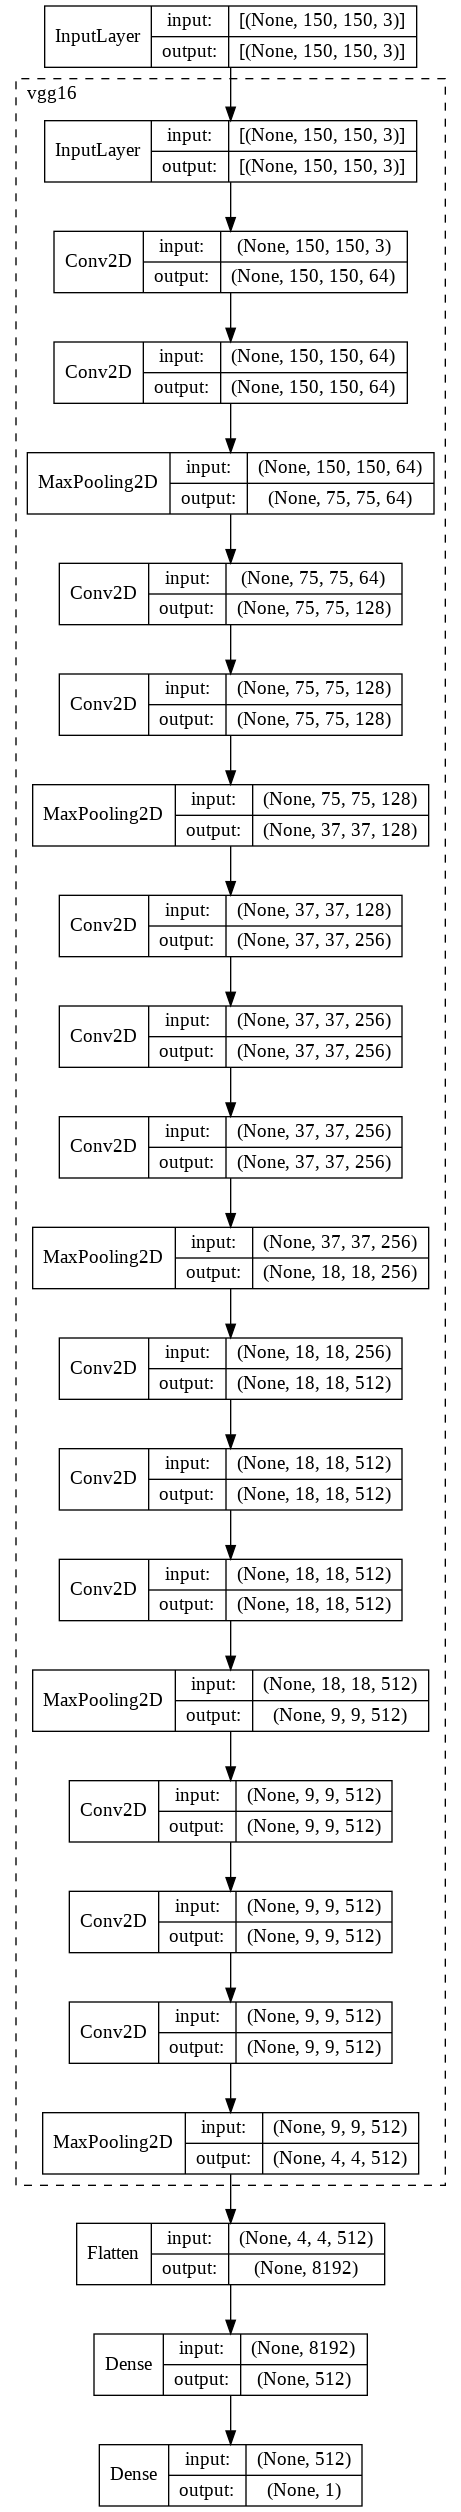

In [ ]:
# Plot the vgg architecture
vgg_architecture = vgg_creation(summary=False)
plot_model(vgg_architecture, to_file='vgg_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

### Features extraction

#### Vanilla

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 22s 832ms/step - loss: 0.8312 - acc: 0.6254 - val_loss: 0.5617 - val_acc: 0.7500

Epoch 00001: val_loss improved fro

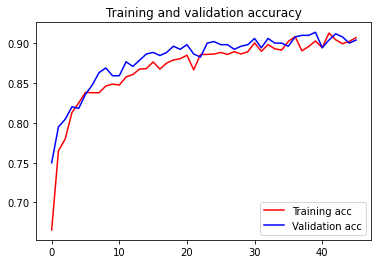

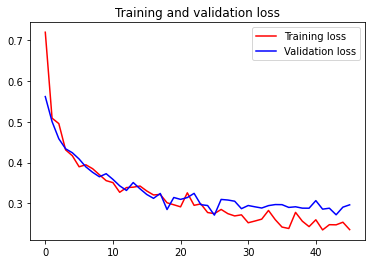

Specificity :  0.8715083798882681
Sensitivity :  0.7579617834394905


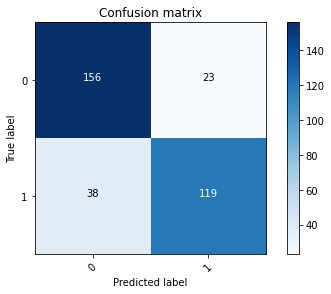

              precision    recall  f1-score   support

           0     0.8041    0.8715    0.8365       179
           1     0.8380    0.7580    0.7960       157

    accuracy                         0.8185       336
   macro avg     0.8211    0.8147    0.8162       336
weighted avg     0.8200    0.8185    0.8175       336



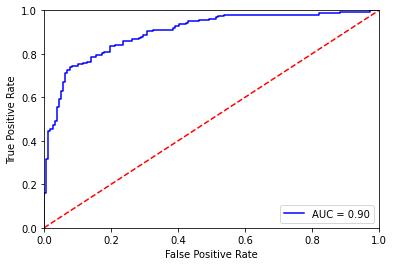

In [ ]:
set_seed()

vgg1 = vgg_creation()

vgg_model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg1_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
vgg_callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

adam = keras.optimizers.Adam()
rms = keras.optimizers.RMSprop(learning_rate=2e-5)

vgg1.compile(loss='binary_crossentropy',
              optimizer=rms,
              metrics=['acc'])

history = vgg1.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [vgg_callback, vgg_model_checkpoint]
)

vgg1.save(os.path.join(MODEL_PATH, 'vgg1.h5'))
best_vgg1 = models.load_model(os.path.join(MODEL_PATH, 'vgg1_best.h5'))
performance_plot(history, best_vgg1, vgg_test_generator)

#### Smaller FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 13s 755ms/step - loss: 2.1880 - acc: 0.6363 - val_loss: 0.4892 - val_acc: 0.7637

Epoch 00001: val_loss improved from inf to 0.48916, saving model to /content/drive/Shareddrives/Ver

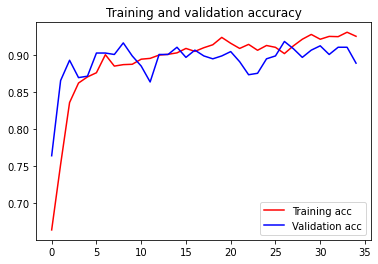

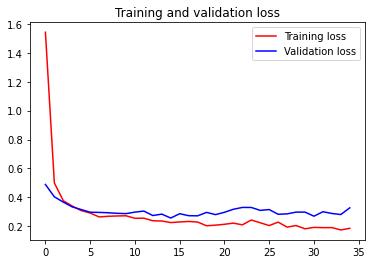

Specificity :  0.9050279329608939
Sensitivity :  0.7579617834394905


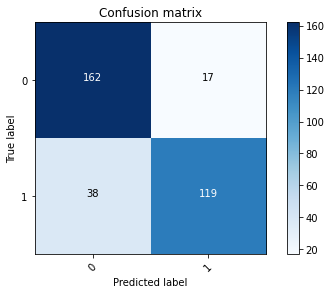

              precision    recall  f1-score   support

           0     0.8100    0.9050    0.8549       179
           1     0.8750    0.7580    0.8123       157

    accuracy                         0.8363       336
   macro avg     0.8425    0.8315    0.8336       336
weighted avg     0.8404    0.8363    0.8350       336



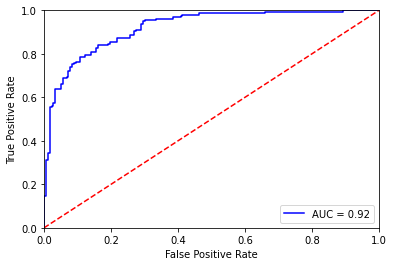

In [ ]:
set_seed()

vgg2 = vgg_creation(fc_dense=[256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg2_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = vgg2.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg2.save(os.path.join(MODEL_PATH, 'vgg2.h5'))
best_vgg2 = models.load_model(os.path.join(MODEL_PATH, 'vgg2_best.h5'))
performance_plot(history, best_vgg2, vgg_test_generator)

#### Smaller FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,763,521
Trainable params: 1,048,833
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 12s 736ms/step - loss: 1.2900 - acc: 0.6565 - val_loss: 0.4611 - val_acc: 0.8281

Epoch 00001: val_loss improved from inf to 0.46113, saving model to /content/drive/Shareddrives/Ver

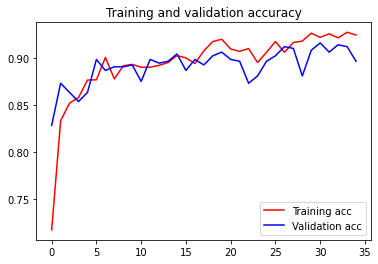

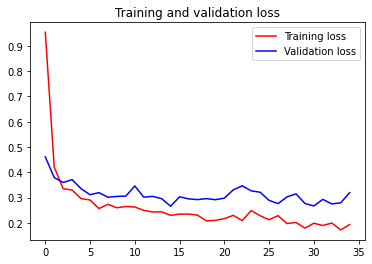

Specificity :  0.9050279329608939
Sensitivity :  0.7707006369426752


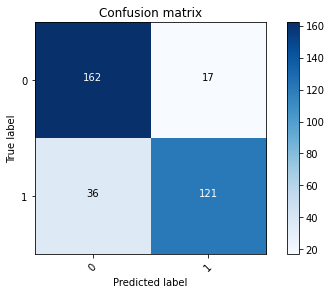

              precision    recall  f1-score   support

           0     0.8182    0.9050    0.8594       179
           1     0.8768    0.7707    0.8203       157

    accuracy                         0.8423       336
   macro avg     0.8475    0.8379    0.8399       336
weighted avg     0.8456    0.8423    0.8412       336



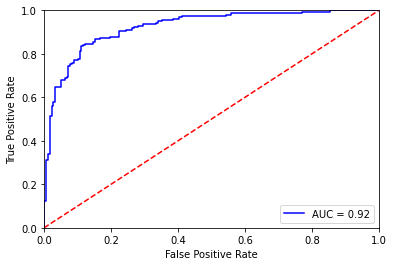

In [ ]:
set_seed()

vgg3 = vgg_creation(fc_dense=[128])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg3_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg3.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = vgg3.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg3.save(os.path.join(MODEL_PATH, 'vgg3.h5'))
best_vgg3 = models.load_model(os.path.join(MODEL_PATH, 'vgg3_best.h5'))
performance_plot(history, best_vgg3, vgg_test_generator)

#### 2 FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 16,845,121
Trainable params: 2,130,433
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 13s 747ms/step - loss: 0.8577 - acc: 0.6598 - val

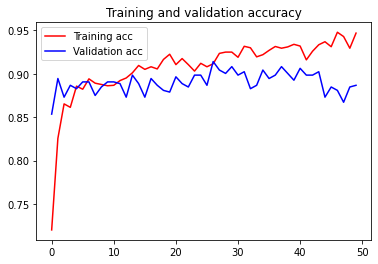

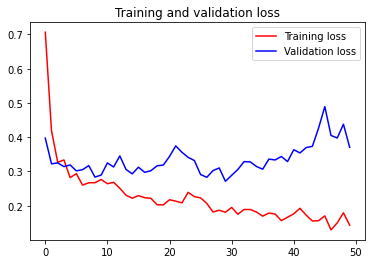

Specificity :  0.9162011173184358
Sensitivity :  0.7898089171974523


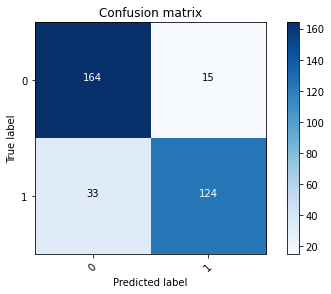

              precision    recall  f1-score   support

           0     0.8325    0.9162    0.8723       179
           1     0.8921    0.7898    0.8378       157

    accuracy                         0.8571       336
   macro avg     0.8623    0.8530    0.8551       336
weighted avg     0.8603    0.8571    0.8562       336



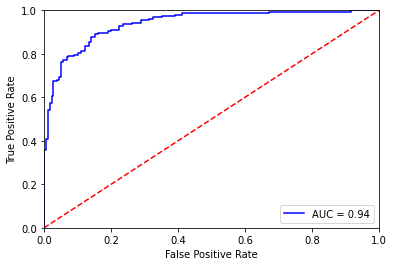

In [ ]:
set_seed()

vgg4 = vgg_creation(fc_dense=[256, 128])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg4_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

vgg4.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = vgg4.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg4.save(os.path.join(MODEL_PATH, 'vgg4.h5'))
best_vgg4 = models.load_model(os.path.join(MODEL_PATH, 'vgg4_best.h5'))
performance_plot(history, best_vgg4, vgg_test_generator)

#### With dropout

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 16,845,121
Trainable params: 2,130,433
Non-trainable params: 14,714,688
____________________________________

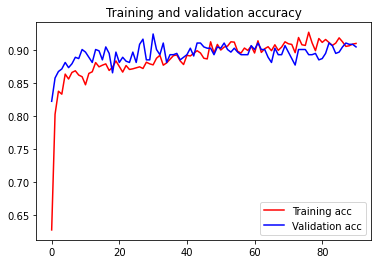

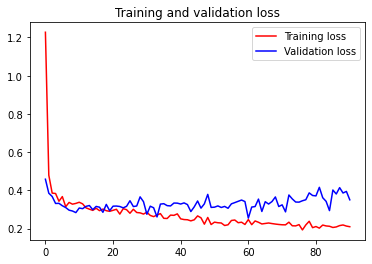

Specificity :  0.8938547486033519
Sensitivity :  0.802547770700637


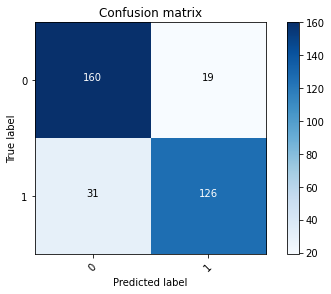

              precision    recall  f1-score   support

           0     0.8377    0.8939    0.8649       179
           1     0.8690    0.8025    0.8344       157

    accuracy                         0.8512       336
   macro avg     0.8533    0.8482    0.8497       336
weighted avg     0.8523    0.8512    0.8506       336



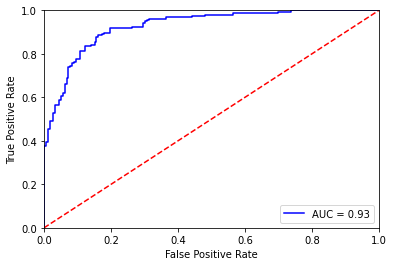

In [ ]:
set_seed()

vgg5 = vgg_creation(fc_dense=[0.5, 256, 128])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg5_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=30)

vgg5.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = vgg5.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg5.save(os.path.join(MODEL_PATH, 'vgg5.h5'))
best_vgg5 = models.load_model(os.path.join(MODEL_PATH, 'vgg5_best.h5'))
performance_plot(history, best_vgg5, vgg_test_generator)

### Fine tuning

#### 1 layer

In [ ]:
vgg16_1_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg4_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
for layer in vgg16_1_layers.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

vgg16_1_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

vgg16_1_layers.summary()
for i, layer in enumerate(vgg16_1_layers.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 16,845,121
Trainable params: 4,490,241
Non-trainable params: 12,354,880
_________________________________________________________________
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 b

Epoch 1/50
16/16 [==============================] - 13s 744ms/step - loss: 3.5538 - acc: 0.6762 - val_loss: 0.5505 - val_acc: 0.8301

Epoch 00001: val_loss improved from inf to 0.55055, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/vgg16_1_layers_best.h5
Epoch 2/50
16/16 [==============================] - 12s 734ms/step - loss: 0.4993 - acc: 0.7953 - val_loss: 0.3605 - val_acc: 0.8613

Epoch 00002: val_loss improved from 0.55055 to 0.36054, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/vgg16_1_layers_best.h5
Epoch 3/50
16/16 [==============================] - 12s 734ms/step - loss: 0.3485 - acc: 0.8634 - val_loss: 0.3224 - val_acc: 0.8945

Epoch 00003: val_loss improved from 0.36054 to 0.32236, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/vgg16_1_layers_best.h5
Epoch 4/50
16/16 [==============================] - 12s 746ms/step - loss: 0.3070 - acc: 0.8721 - val_loss: 0.327

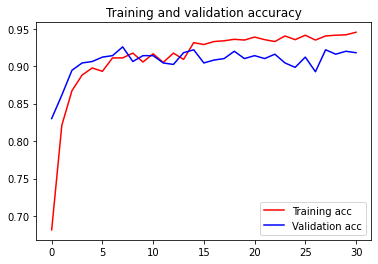

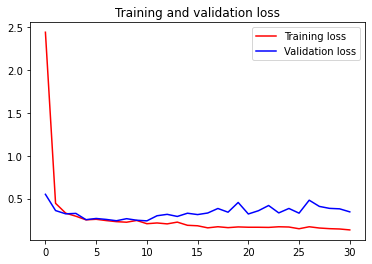

Specificity :  0.9162011173184358
Sensitivity :  0.8471337579617835


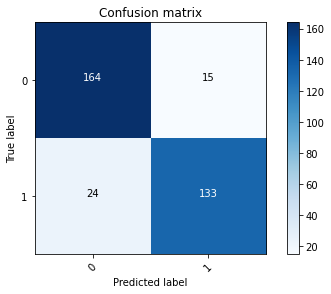

              precision    recall  f1-score   support

           0     0.8723    0.9162    0.8937       179
           1     0.8986    0.8471    0.8721       157

    accuracy                         0.8839       336
   macro avg     0.8855    0.8817    0.8829       336
weighted avg     0.8846    0.8839    0.8836       336



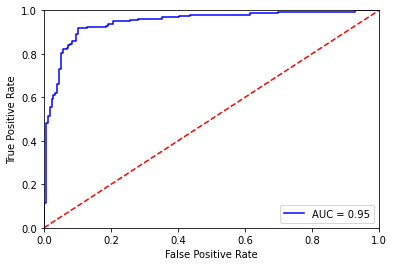

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg16_1_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

history = vgg16_1_layers.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 50,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg16_1_layers.save(os.path.join(MODEL_PATH, 'vgg16_1_layers.h5'))
best_vgg16_1_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg16_1_layers_best.h5'))
performance_plot(history, best_vgg16_1_layers, vgg_test_generator)

#### 3 layer

In [ ]:
vgg16_3_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg16_1_layers_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
for layer in vgg16_3_layers.get_layer('vgg16').layers:
    if layer.name in ('block5_conv3','block5_conv2','block5_conv1'):
        layer.trainable = True
    else:
        layer.trainable = False

vgg16_3_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

vgg16_3_layers.summary()
for i, layer in enumerate(vgg16_3_layers.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 16,845,121
Trainable params: 9,209,857
Non-trainable params: 7,635,264
_________________________________________________________________
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 bl

Epoch 1/50
16/16 [==============================] - 13s 767ms/step - loss: 12.7873 - acc: 0.6066 - val_loss: 0.8549 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 0.85494, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/vgg16_3_layers_best.h5
Epoch 2/50
16/16 [==============================] - 12s 770ms/step - loss: 0.8639 - acc: 0.5443 - val_loss: 0.6928 - val_acc: 0.5332

Epoch 00002: val_loss improved from 0.85494 to 0.69282, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/vgg16_3_layers_best.h5
Epoch 3/50
16/16 [==============================] - 13s 782ms/step - loss: 0.6982 - acc: 0.4815 - val_loss: 0.6921 - val_acc: 0.5312

Epoch 00003: val_loss improved from 0.69282 to 0.69205, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/vgg16_3_layers_best.h5
Epoch 4/50
16/16 [==============================] - 12s 763ms/step - loss: 0.6928 - acc: 0.5237 - val_loss: 0.67

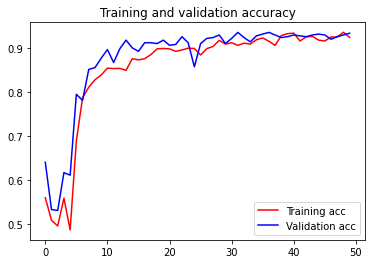

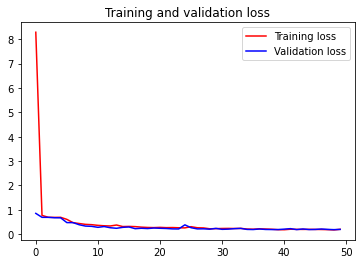

Specificity :  0.9162011173184358
Sensitivity :  0.8662420382165605


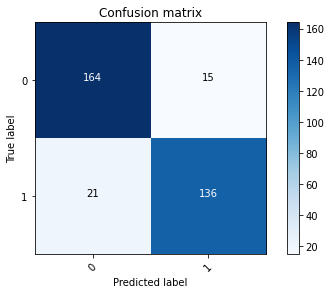

              precision    recall  f1-score   support

           0     0.8865    0.9162    0.9011       179
           1     0.9007    0.8662    0.8831       157

    accuracy                         0.8929       336
   macro avg     0.8936    0.8912    0.8921       336
weighted avg     0.8931    0.8929    0.8927       336



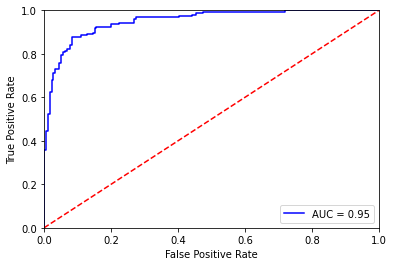

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'vgg16_3_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

history = vgg16_3_layers.fit(
    vgg_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 50,
    validation_data = vgg_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

vgg16_3_layers.save(os.path.join(MODEL_PATH, 'vgg16_3_layers.h5'))
best_vgg16_3_layers = models.load_model(os.path.join(MODEL_PATH, 'vgg16_3_layers_best.h5'))
performance_plot(history, best_vgg16_3_layers, vgg_test_generator)

## Resnet

### Preprocessing

In [ ]:
resnet_train_datagen = ImageDataGenerator(
    preprocessing_function=resnet_process_input,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

resnet_datagen = ImageDataGenerator(
     preprocessing_function=resnet_process_input
)

In [ ]:
resnet_train_datagen.fit(train_images)
resnet_train_generator = resnet_train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

#resnet_process_input(valid_images)
resnet_validation_generator = resnet_datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)

resnet_test_generator = resnet_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0], shuffle=False)

### Model definition ResNet50

In [ ]:
def resnet_creation(fc_dense = [512], summary=True):
    resnet_base = ResNet50(weights='imagenet',
                           include_top = False, # togliamo l'ultimo livello per classificare quello che vogliamo
                           input_shape=(150, 150, 3))

    # set_trainable = False
    # for layer in resnet.layers:
    #     layer.trainable = set_trainable
    resnet_base.trainable = False

    resnet = models.Sequential()
    resnet.add(resnet_base)

    resnet.add(layers.Flatten())

    for d in fc_dense:
      if d < 1:
        resnet.add(layers.Dropout(d))
      else:
        resnet.add(layers.Dense(d, activation='relu'))
    resnet.add(layers.Dense(1, activation='sigmoid'))

    if summary:
        resnet.summary()

    return resnet

In [ ]:
# Plot the resnet archtecture
resnet_architecture = resnet_creation(summary=False)
plot_model(resnet_architecture, to_file='resnet_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

Output hidden; open in https://colab.research.google.com to view.

### Features extraction

#### Vanilla



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 49,803,137
Trainable params: 26,215,425
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 16s 766ms/step - loss: 6.3943 - acc: 0.6116 - val_loss: 0.7773 - val_acc: 0.8164

Epoch 00001: val_loss improved from inf to 0.77726, saving model to /content/drive/Shareddrives/Ve

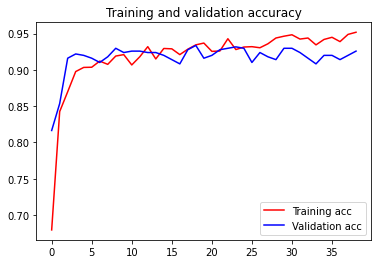

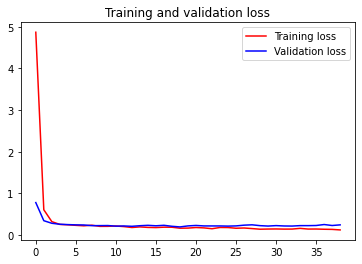

Specificity :  0.9162011173184358
Sensitivity :  0.8089171974522293


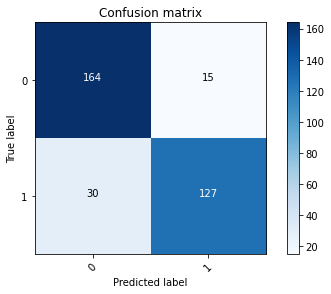

              precision    recall  f1-score   support

           0     0.8454    0.9162    0.8794       179
           1     0.8944    0.8089    0.8495       157

    accuracy                         0.8661       336
   macro avg     0.8699    0.8626    0.8644       336
weighted avg     0.8683    0.8661    0.8654       336



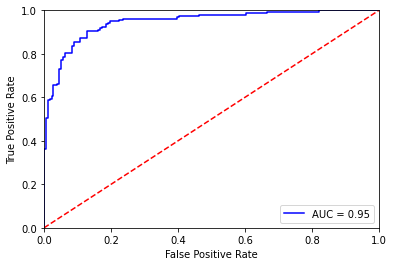

In [ ]:
set_seed()

resnet1 = resnet_creation()

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'resnet1_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

resnet1.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

history = resnet1.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)
resnet1.save(os.path.join(MODEL_PATH, 'resnet1.h5'))
best_resnet1 = models.load_model(os.path.join(MODEL_PATH, 'resnet1_best.h5'))
performance_plot(history, best_resnet1, resnet_test_generator)

#### Smaller FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               13107456  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 36,695,425
Trainable params: 13,107,713
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 15s 759ms/step - loss: 6.3744 - acc: 0.5656 - val_loss: 0.5914 - val_acc: 0.6875

Epoch 00001: val_loss improved from inf to 0.59145, saving model to /content/drive/Shareddrives/Ve

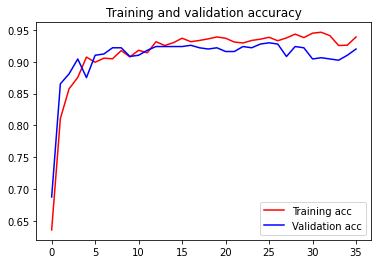

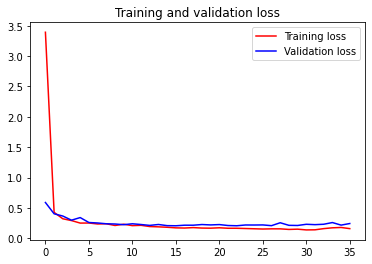

Specificity :  0.9162011173184358
Sensitivity :  0.8280254777070064


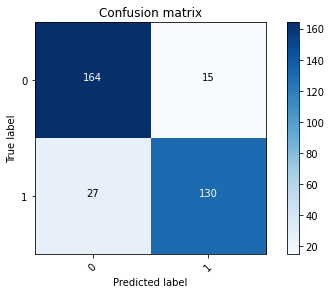

              precision    recall  f1-score   support

           0     0.8586    0.9162    0.8865       179
           1     0.8966    0.8280    0.8609       157

    accuracy                         0.8750       336
   macro avg     0.8776    0.8721    0.8737       336
weighted avg     0.8764    0.8750    0.8745       336



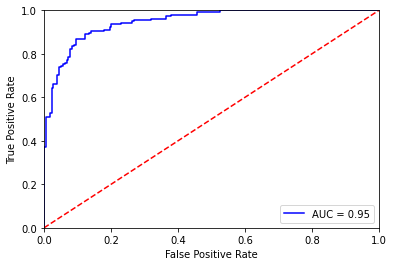

In [ ]:
# resnet50
set_seed()

resnet2 = resnet_creation(fc_dense=[256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'resnet2_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

resnet2.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

history = resnet2.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)
resnet2.save(os.path.join(MODEL_PATH, 'resnet2.h5'))
best_resnet2 = models.load_model(os.path.join(MODEL_PATH, 'resnet2_best.h5'))
performance_plot(history, best_resnet2, resnet_test_generator)

#### 2 FC layers

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 49,934,209
Trainable params: 26,346,497
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/100
16/16 [=================

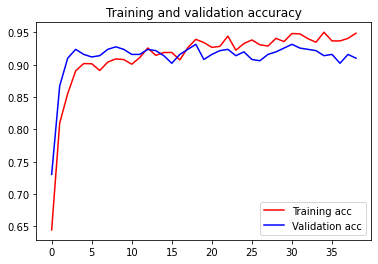

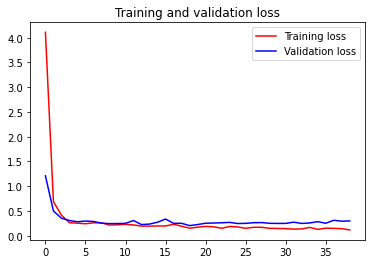

Specificity :  0.9217877094972067
Sensitivity :  0.8407643312101911


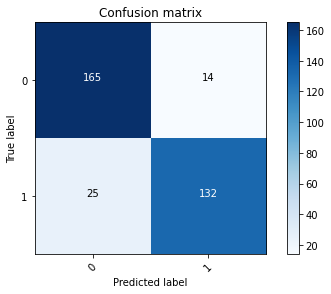

              precision    recall  f1-score   support

           0     0.8684    0.9218    0.8943       179
           1     0.9041    0.8408    0.8713       157

    accuracy                         0.8839       336
   macro avg     0.8863    0.8813    0.8828       336
weighted avg     0.8851    0.8839    0.8836       336



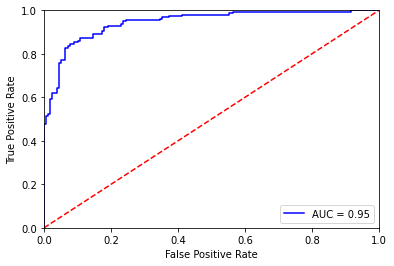

In [ ]:
# resnet50
set_seed()

resnet3 = resnet_creation(fc_dense=[512, 256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, 'resnet3_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

resnet3.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

history = resnet3.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)
resnet3.save(os.path.join(MODEL_PATH, 'resnet3.h5'))
best_resnet3 = models.load_model(os.path.join(MODEL_PATH, 'resnet3_best.h5'))
performance_plot(history, best_resnet3, resnet_test_generator)

### Fine tuning

#### 1 layer

In [ ]:
resnet_1_layers = models.load_model(os.path.join(MODEL_PATH, 'resnet3_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
for layer in resnet_1_layers.get_layer('resnet50').layers:
    if layer.name in ('conv5_block3_3_conv'): #, 'conv5_block3_2_conv'):
        layer.trainable = True
    else:
        layer.trainable = False

resnet_1_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(),
                metrics=['acc'])

resnet_1_layers.summary()
for i, layer in enumerate(resnet_1_layers.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 49,934,209
Trainable params: 27,397,121
Non-trainable params: 22,537,088
_________________________________________________________________
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad 

Epoch 1/100
16/16 [==============================] - 15s 783ms/step - loss: 1.2063 - acc: 0.7997 - val_loss: 0.3859 - val_acc: 0.8691

Epoch 00001: val_loss improved from inf to 0.38590, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/resnet_1_layers_best.h5
Epoch 2/100
16/16 [==============================] - 12s 736ms/step - loss: 0.2387 - acc: 0.9037 - val_loss: 0.2368 - val_acc: 0.9336

Epoch 00002: val_loss improved from 0.38590 to 0.23680, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/resnet_1_layers_best.h5
Epoch 3/100
16/16 [==============================] - 12s 743ms/step - loss: 0.2223 - acc: 0.9131 - val_loss: 0.2238 - val_acc: 0.9316

Epoch 00003: val_loss improved from 0.23680 to 0.22383, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/resnet_1_layers_best.h5
Epoch 4/100
16/16 [==============================] - 13s 776ms/step - loss: 0.2122 - acc: 0.9151 - val_loss

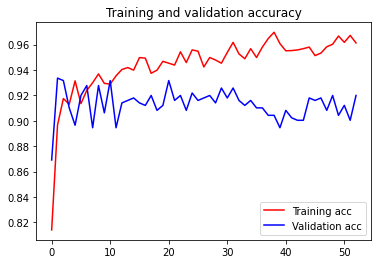

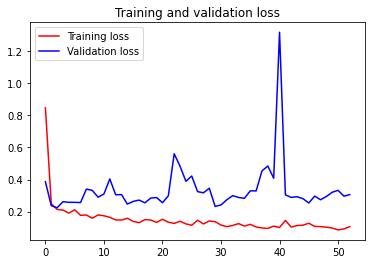

Specificity :  0.9273743016759777
Sensitivity :  0.8471337579617835


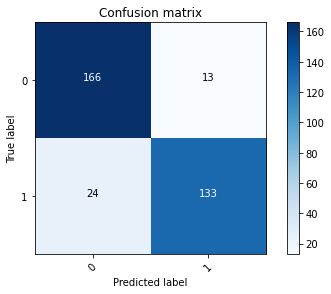

              precision    recall  f1-score   support

           0     0.8737    0.9274    0.8997       179
           1     0.9110    0.8471    0.8779       157

    accuracy                         0.8899       336
   macro avg     0.8923    0.8873    0.8888       336
weighted avg     0.8911    0.8899    0.8895       336



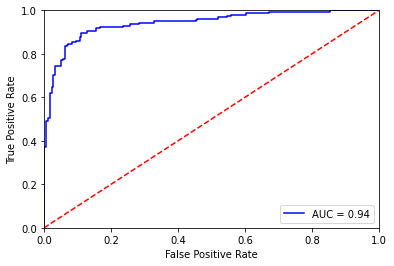

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'resnet_1_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = resnet_1_layers.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

resnet_1_layers.save(os.path.join(MODEL_PATH, 'resnet_1_layers.h5'))
best_resnet_1_layers = models.load_model(os.path.join(MODEL_PATH, 'resnet_1_layers_best.h5'))
performance_plot(history, best_resnet_1_layers, resnet_test_generator)

#### N layer

In [ ]:
N = 10

resnet_N_layers = models.load_model(os.path.join(MODEL_PATH, 'resnet_1_layers_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
resnet_N_layers.trainable = False
for layer in resnet_N_layers.get_layer('resnet50').layers[165:]:
    #print(layer.name)
    layer.trainable = True

resnet_N_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['acc'])

resnet_N_layers.summary()
for i, layer in enumerate(resnet_N_layers.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               26214912  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 49,934,209
Trainable params: 30,812,161
Non-trainable params: 19,122,048
_________________________________________________________________
0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad 

Epoch 1/100
16/16 [==============================] - 16s 806ms/step - loss: 0.2899 - acc: 0.8901 - val_loss: 0.2233 - val_acc: 0.9355

Epoch 00001: val_loss improved from inf to 0.22334, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/resnet_N_layers_best.h5
Epoch 2/100
16/16 [==============================] - 13s 775ms/step - loss: 0.2310 - acc: 0.9181 - val_loss: 0.2237 - val_acc: 0.9355

Epoch 00002: val_loss did not improve from 0.22334
Epoch 3/100
16/16 [==============================] - 12s 745ms/step - loss: 0.1897 - acc: 0.9216 - val_loss: 0.2189 - val_acc: 0.9375

Epoch 00003: val_loss improved from 0.22334 to 0.21887, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/resnet_N_layers_best.h5
Epoch 4/100
16/16 [==============================] - 13s 780ms/step - loss: 0.1924 - acc: 0.9325 - val_loss: 0.2109 - val_acc: 0.9277

Epoch 00004: val_loss improved from 0.21887 to 0.21095, saving model to /content/driv

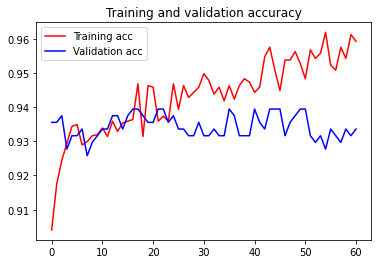

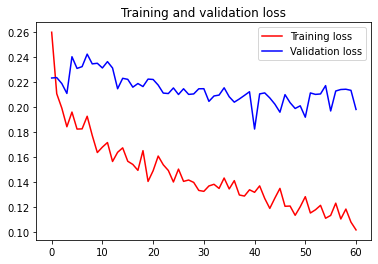

Specificity :  0.9217877094972067
Sensitivity :  0.8343949044585988


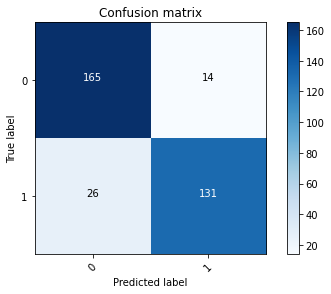

              precision    recall  f1-score   support

           0     0.8639    0.9218    0.8919       179
           1     0.9034    0.8344    0.8675       157

    accuracy                         0.8810       336
   macro avg     0.8837    0.8781    0.8797       336
weighted avg     0.8824    0.8810    0.8805       336



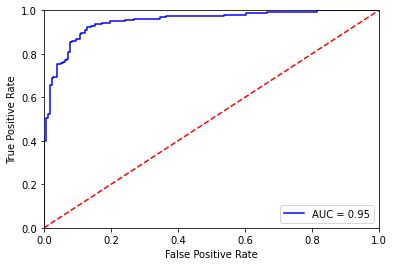

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'resnet_N_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

history = resnet_N_layers.fit(
    resnet_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    validation_data = resnet_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

resnet_N_layers.save(os.path.join(MODEL_PATH, 'resnet_N_layers.h5'))
best_resnet_N_layers = models.load_model(os.path.join(MODEL_PATH, 'resnet_N_layers_best.h5'))
performance_plot(history, best_resnet_N_layers, resnet_test_generator)

## Inception

### Preprocessing

In [ ]:
inception_train_datagen = ImageDataGenerator(
    preprocessing_function=inception_process_input,
    rotation_range=180,
    vertical_flip = True,
    horizontal_flip = True
)

inception_datagen = ImageDataGenerator(
     preprocessing_function=inception_process_input
)

In [ ]:
inception_train_datagen.fit(train_images)
inception_train_generator = inception_train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)

#inception_preprocess_input(valid_images)
inception_validation_generator = inception_datagen.flow(valid_images, valid_labels, batch_size=BATCH_SIZE)

inception_test_generator = inception_datagen.flow(test_images, test_labels, batch_size=test_images.shape[0], shuffle=False)

### Model definition

In [ ]:
def inception_creation(fc_dense = [512], summary=True):
    inception_base = InceptionV3(weights='imagenet',
                    include_top=False, # togliamo l'ultimo livello per classificare quello che vogliamo
                    input_shape=(150, 150, 3))

    inception_base.trainable = False

    inception = models.Sequential()
    inception.add(inception_base)
    inception.add(layers.Flatten())

    for d in fc_dense:
      if d < 1:
        inception.add(layers.Dropout(d))
      else:
        inception.add(layers.Dense(d, activation='relu'))
    
    inception.add(layers.Dense(1, activation='sigmoid'))
    inception.summary()

    return inception

In [ ]:
# Plot the inception archtecture
inception_architecture = inception_creation(fc_dense=[512,256], summary=False)
plot_model(inception_architecture, to_file='inception_architecture.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True)

Output hidden; open in https://colab.research.google.com to view.

#### Vanilla

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 31,240,993
Trainable params: 9,438,209
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 21s 690ms/step - loss: 3.2777 - acc: 0.5372 - val_loss: 0.6396 - val_acc: 0.6719

Epoch 00001: val_loss improved from inf to 0.63964, saving model to /content/drive/Shareddrives/Vern

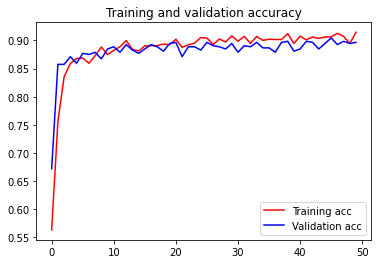

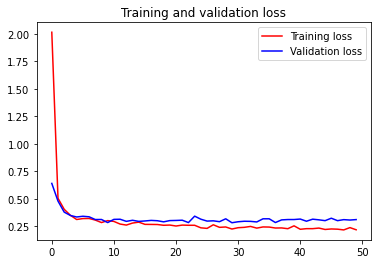

Specificity :  0.9273743016759777
Sensitivity :  0.8471337579617835


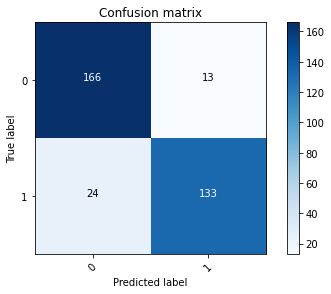

              precision    recall  f1-score   support

           0     0.8737    0.9274    0.8997       179
           1     0.9110    0.8471    0.8779       157

    accuracy                         0.8899       336
   macro avg     0.8923    0.8873    0.8888       336
weighted avg     0.8911    0.8899    0.8895       336



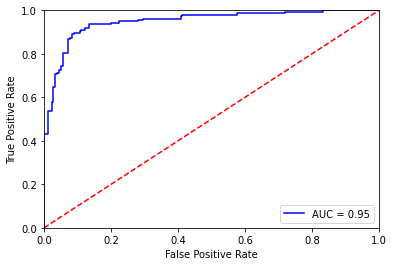

In [ ]:
set_seed() 

inception1 = inception_creation()

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception1_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

inception1.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = inception1.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception1.save(os.path.join(MODEL_PATH, 'inception1.h5'))
best_inception1 = models.load_model(os.path.join(MODEL_PATH, 'inception1_best.h5'))
performance_plot(history, best_inception1, inception_test_generator)

#### Smaller FC layer

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               4718848   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 4,719,105
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 14s 702ms/step - loss: 1.9162 - acc: 0.5583 - val_loss: 0.5732 - val_acc: 0.7168

Epoch 00001: val_loss improved from inf to 0.57320, saving model to /content/drive/Shareddrives/Ver

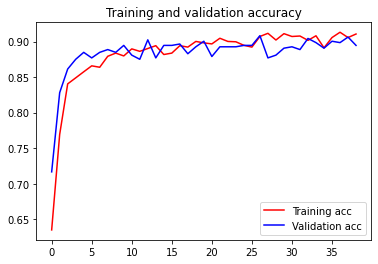

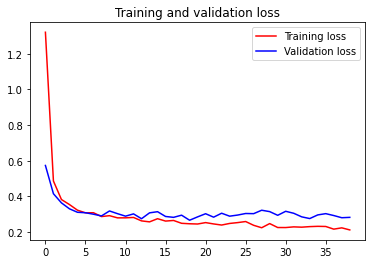

Specificity :  0.8994413407821229
Sensitivity :  0.8726114649681529


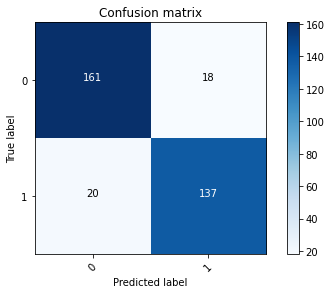

              precision    recall  f1-score   support

           0     0.8895    0.8994    0.8944       179
           1     0.8839    0.8726    0.8782       157

    accuracy                         0.8869       336
   macro avg     0.8867    0.8860    0.8863       336
weighted avg     0.8869    0.8869    0.8869       336



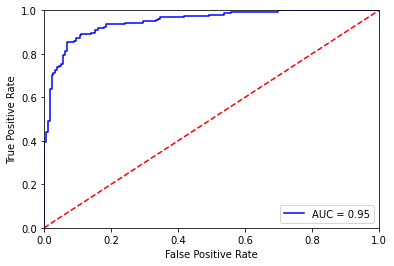

In [ ]:
set_seed() 

inception2 = inception_creation(fc_dense=[256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception2_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

inception2.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = inception2.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception2.save(os.path.join(MODEL_PATH, 'inception2.h5'))

best_inception2 = models.load_model(os.path.join(MODEL_PATH, 'inception2_best.h5'))

performance_plot(history, best_inception2, inception_test_generator)


#### 2 FC layers

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 31,372,065
Trainable params: 9,569,281
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 14s 679ms/step - loss: 1.1024 - acc: 0.6558 - val

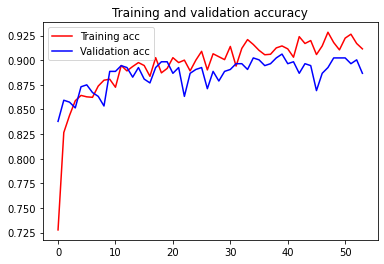

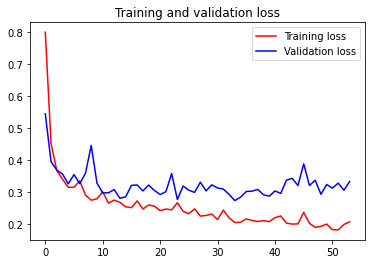

Specificity :  0.9329608938547486
Sensitivity :  0.8789808917197452


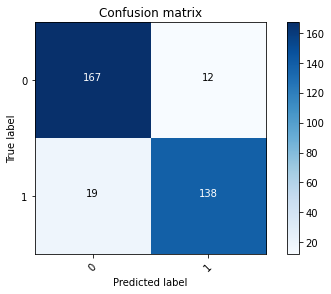

              precision    recall  f1-score   support

           0     0.8978    0.9330    0.9151       179
           1     0.9200    0.8790    0.8990       157

    accuracy                         0.9077       336
   macro avg     0.9089    0.9060    0.9070       336
weighted avg     0.9082    0.9077    0.9076       336



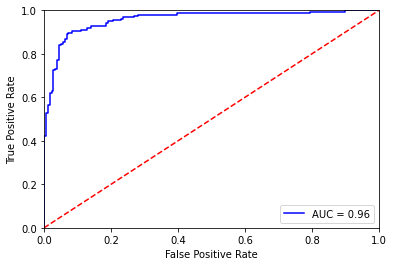

In [ ]:
set_seed() 

inception3 = inception_creation(fc_dense=[512, 256])

model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception3_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=20)

inception3.compile(loss='binary_crossentropy',
              # optimizer=keras.optimizers.RMSprop(lr=2e-5),
              optimizer=keras.optimizers.Adam(),
              metrics=['acc'])

history = inception3.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs=100,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception3.save(os.path.join(MODEL_PATH, 'inception3.h5'))
best_inception3 = models.load_model(os.path.join(MODEL_PATH, 'inception3_best.h5'))
performance_plot(history, best_inception3, inception_test_generator)


### Fine tuning


#### 1 layer

In [ ]:
inception_1_layers = models.load_model(os.path.join(MODEL_PATH, 'inception3_best.h5'))

# Fine tuning: unfreeze all the convolutional layer
for layer in inception_1_layers.get_layer('inception_v3').layers:
    if layer.name in ('conv2d_93'): #, 'conv2d_92'):
        layer.trainable = True
    else:
        layer.trainable = False

inception_1_layers.compile(loss='binary_crossentropy',
                optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                metrics=['acc'])

inception_1_layers.summary()
for i, layer in enumerate(inception_1_layers.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 31,372,065
Trainable params: 10,018,657
Non-trainable params: 21,353,408
_________________________________________________________________
0 input_1 False
1 conv2d True
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch

Epoch 1/100
16/16 [==============================] - 17s 743ms/step - loss: 0.2011 - acc: 0.9248 - val_loss: 0.3015 - val_acc: 0.8926

Epoch 00001: val_loss improved from inf to 0.30148, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/inception_1_layers_best.h5
Epoch 2/100
16/16 [==============================] - 11s 689ms/step - loss: 0.2099 - acc: 0.9034 - val_loss: 0.2972 - val_acc: 0.8945

Epoch 00002: val_loss improved from 0.30148 to 0.29722, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/inception_1_layers_best.h5
Epoch 3/100
16/16 [==============================] - 11s 703ms/step - loss: 0.1813 - acc: 0.9301 - val_loss: 0.2952 - val_acc: 0.8926

Epoch 00003: val_loss improved from 0.29722 to 0.29517, saving model to /content/drive/Shareddrives/Verna_Minutella_Veltroni/models_task3_1/inception_1_layers_best.h5
Epoch 4/100
16/16 [==============================] - 11s 698ms/step - loss: 0.2010 - acc: 0.9232 -

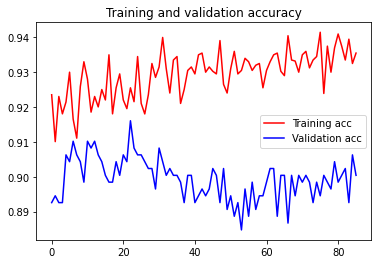

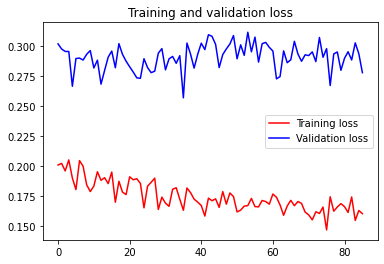

Specificity :  0.9385474860335196
Sensitivity :  0.8726114649681529


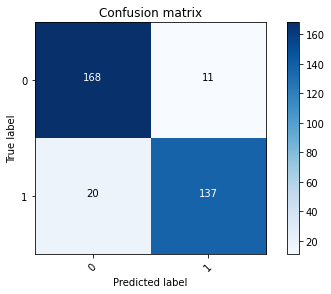

              precision    recall  f1-score   support

           0     0.8936    0.9385    0.9155       179
           1     0.9257    0.8726    0.8984       157

    accuracy                         0.9077       336
   macro avg     0.9096    0.9056    0.9069       336
weighted avg     0.9086    0.9077    0.9075       336



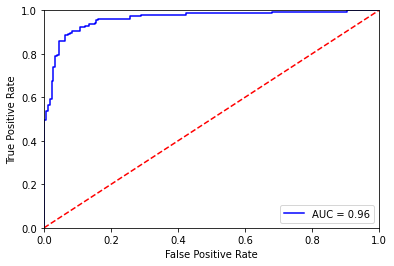

In [ ]:
model_checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH,'inception_1_layers_best.h5'), monitor='val_loss', mode='min', save_best_only=True, verbose=1)
callback = EarlyStopping(monitor='val_loss', mode='min', patience=50)

history = inception_1_layers.fit(
    inception_train_generator,
    steps_per_epoch = len(train_images) // BATCH_SIZE,
    epochs = 100,
    validation_data = inception_validation_generator,
    validation_steps =  len(valid_images) // BATCH_SIZE,
    callbacks = [callback, model_checkpoint]
)

inception_1_layers.save(os.path.join(MODEL_PATH, 'inception_1_layers.h5'))
best_inception_1_layers = models.load_model(os.path.join(MODEL_PATH, 'inception_1_layers_best.h5'))
performance_plot(history, best_inception_1_layers, inception_test_generator)

## Error Analysis

Number of test images: 336
Mispredictions: 31


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


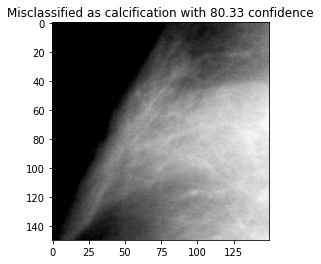

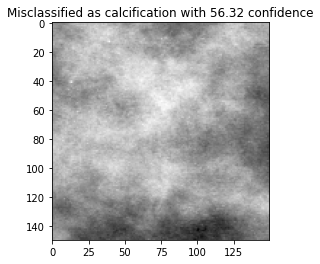

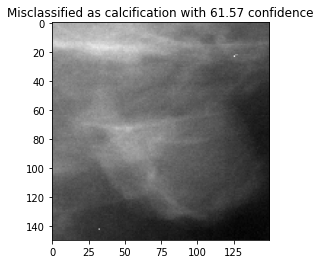

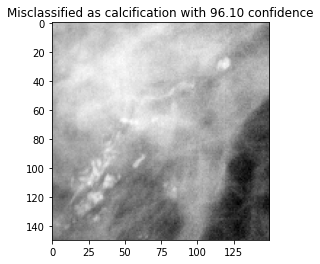

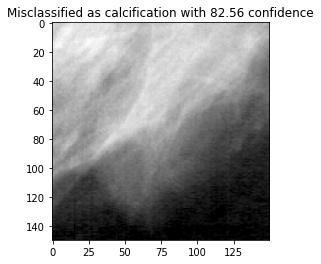

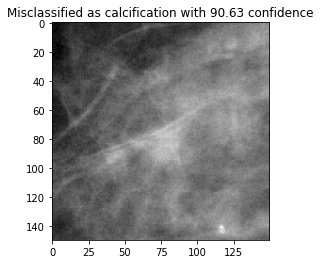

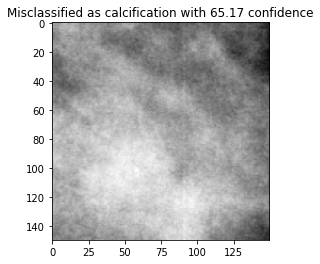

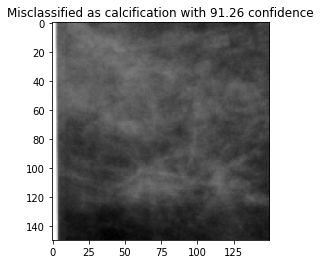

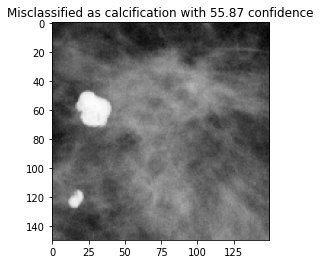

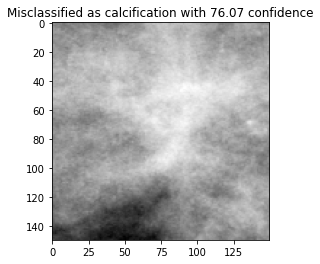

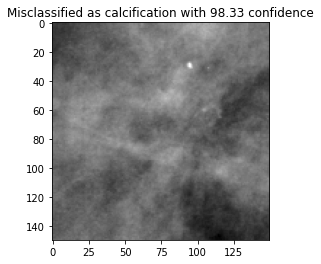

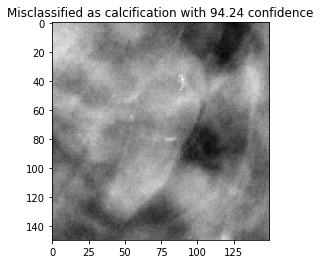

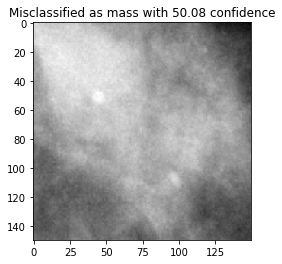

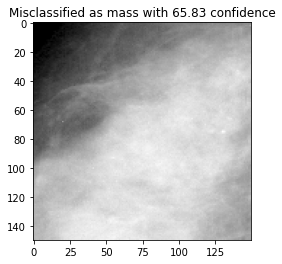

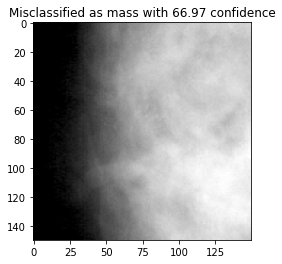

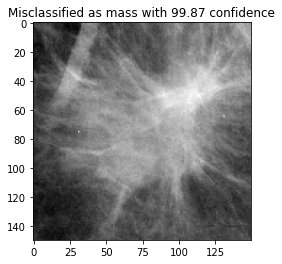

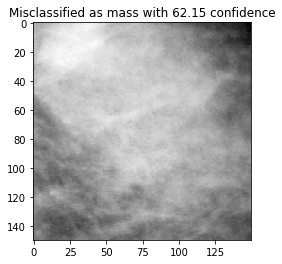

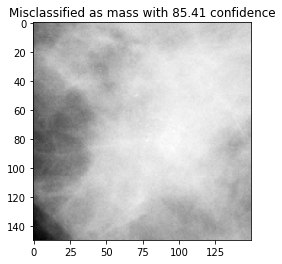

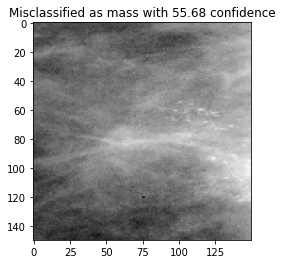

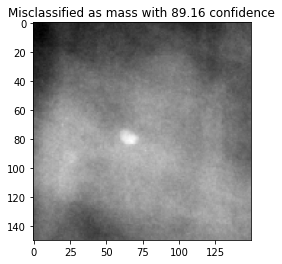

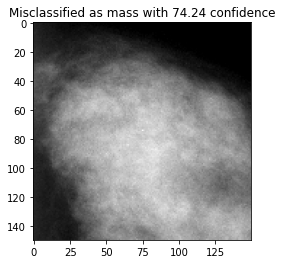

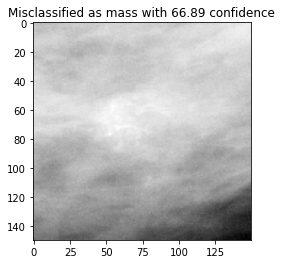

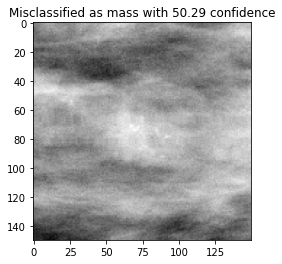

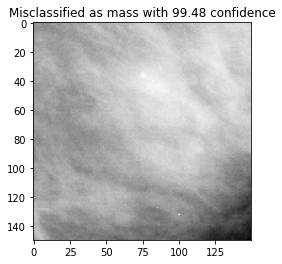

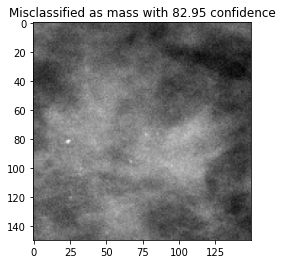

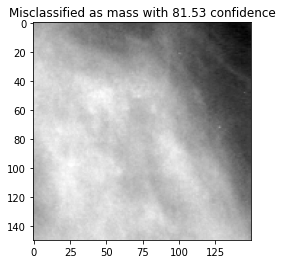

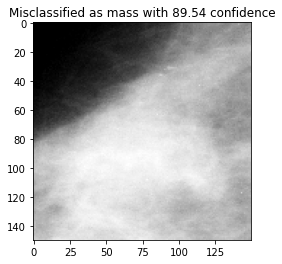

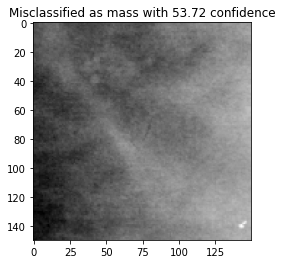

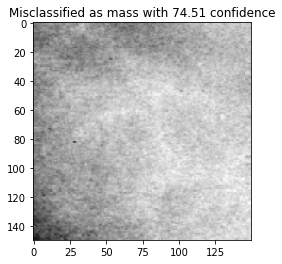

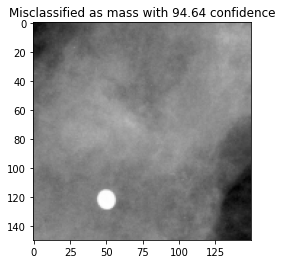

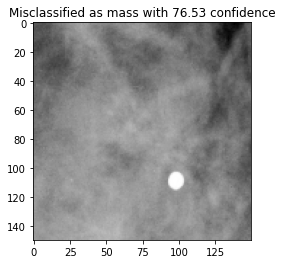

In [ ]:
import seaborn as sns

def get_errors(pred):
    errors = []
    mispred = []

    for l, p, img in zip(inception_test_generator[0][1], pred, inception_test_generator[0][0]):
        err = abs(l-p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))

    return errors, mispred

def show_error_stats(errors, mispred):

    print("Number of test images: %d" % len(inception_test_generator[0][1]))
    print("Mispredictions: %d" % len(mispred))

    #sns.distplot(errors, kde=False, rug=True, bins=10, vertical=False, label='samples', axlabel='error').set_title('Absolute error distribution');

    for l,p,img in mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==1 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        #plt.axis('off')

opt_model = models.load_model(os.path.join(MODEL_PATH, 'inception3_best.h5'))
pred_opt = opt_model.predict(inception_test_generator[0][0])
errors, mispred = get_errors(pred_opt)
show_error_stats(errors, mispred)